# Particle Feynman Benchmark (infodynamics_jax, no GPyTorch)

This notebook replaces the original Torch/GPyTorch implementation with a pure infodynamics_jax workflow:
- Annealed SMC with HMC rejuvenation
- Type-II (VFE) baseline
- Predictive comparison and ESS diagnostics


In [1]:
import os
import sys
from pathlib import Path

os.environ.setdefault('JAX_PLATFORMS', 'cpu')

cwd = Path(os.getcwd())
repo_root = cwd
while repo_root.parent != repo_root:
    if (repo_root / 'infodynamics_jax').exists():
        break
    repo_root = repo_root.parent

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

examples_dir = repo_root / 'examples'
if str(examples_dir) not in sys.path:
    sys.path.insert(0, str(examples_dir))


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels import rbf
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.likelihoods import get as get_likelihood
from infodynamics_jax.gp.predict import predict_typeii
from infodynamics_jax.gp.sparsify import fitc_log_evidence
from infodynamics_jax.energy import InertialEnergy, InertialCFG
from infodynamics_jax.inference.particle import AnnealedSMC, AnnealedSMCCFG
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective

from utils import synthetic, compute_metrics, setup_plot_style, COLORS, plot_with_uncertainty

matplotlib.use('module://matplotlib_inline.backend_inline')
jax.config.update('jax_enable_x64', True)

setup_plot_style()


## Config


In [3]:
class CFG:
    N_train = 120
    N_test = 60
    noise_std = 0.2
    domain = (-2.5, 2.5)
    M = 20
    n_particles = 64
    n_steps = 24
    ess_threshold = 0.6
    rejuvenation = 'hmc'
    rejuvenation_steps = 2
    step_size = 0.02
    n_leapfrog = 8
    bma_samples = 80
    typeii_steps = 300
    typeii_lr = 1e-2

cfg = CFG()


## Data (one function)


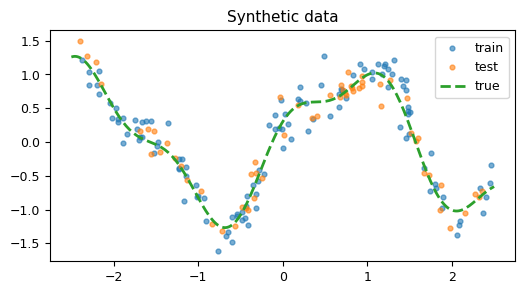

In [4]:
key = jax.random.key(0)
fn, title, desc, category = synthetic.get('sine_mix')

key, subkey = jax.random.split(key)
X_all, Y_all, _ = synthetic.sample(
    'sine_mix',
    N=cfg.N_train + cfg.N_test,
    noise=cfg.noise_std,
    domain=cfg.domain,
    key=subkey,
)
X_all = X_all[:, None]

key, subkey = jax.random.split(key)
perm = jax.random.permutation(subkey, X_all.shape[0])
train_idx = perm[:cfg.N_train]
test_idx = perm[cfg.N_train:]

X_train = X_all[train_idx]
Y_train = Y_all[train_idx]
X_test = X_all[test_idx]
Y_test = Y_all[test_idx]

X_plot = jnp.linspace(cfg.domain[0], cfg.domain[1], 240)[:, None]
Y_plot = fn(X_plot[:, 0])

plt.figure(figsize=(6, 3))
plt.scatter(np.array(X_train[:, 0]), np.array(Y_train), s=12, alpha=0.6, color=COLORS['train'], label='train')
plt.scatter(np.array(X_test[:, 0]), np.array(Y_test), s=12, alpha=0.6, color=COLORS['test'], label='test')
plt.plot(np.array(X_plot[:, 0]), np.array(Y_plot), color=COLORS['true'], lw=2, ls='--', label='true')
plt.title('Synthetic data')
plt.legend()
plt.show()


## Phi + Energy


In [5]:
Z = jnp.linspace(cfg.domain[0], cfg.domain[1], cfg.M)[:, None]
phi_init = Phi(
    kernel_params=KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0)),
    Z=Z,
    likelihood_params={'noise_var': jnp.array(cfg.noise_std**2)},
    jitter=1e-6,
)

gaussian_likelihood = get_likelihood('gaussian')
energy = InertialEnergy(
    kernel_fn=rbf,
    likelihood=gaussian_likelihood,
    cfg=InertialCFG(estimator='analytic', gh_n=20, inner_steps=0),
    residual='fitc',
)


## Annealed SMC (Array-only, fully JIT-compiled)

**關鍵優化：使用純 array 表示 + lax.scan，完全避免 Python object 和 Python loop，讓 JAX 可以真正 JIT 編譯整個 SMC**


## Array-only SMC (fast path)

We run annealed SMC on a *pure array state* `theta = [log_ell, log_sf2, log_sn2, Z_flat]`.
This avoids Python objects (Phi/KernelParams) inside the SMC loop, so `lax.scan` + JIT can fully compile.
Prediction later converts a sampled `theta` back to `Phi` for plotting.


開始運行 SMC（第一次會編譯，請稍候）...
SMC 完成！耗時: 2.17 秒


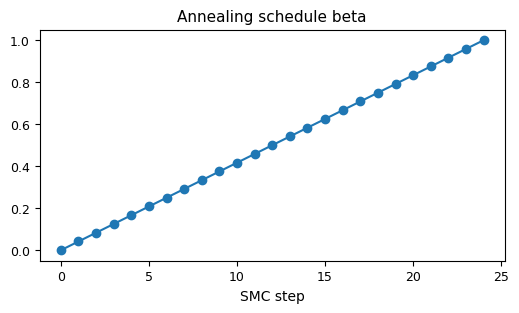

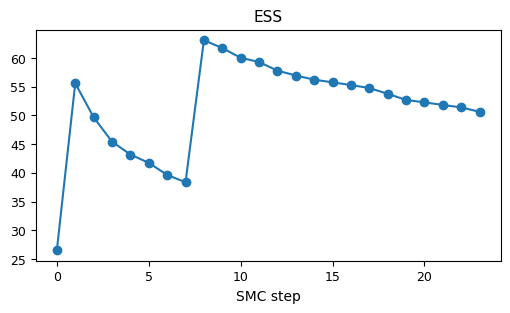

In [6]:
import sys
from pathlib import Path
cwd = Path.cwd().resolve()
candidates = [cwd, *cwd.parents]
for p in candidates:
    ex = p / 'examples'
    if (ex / 'smc_array_only.py').is_file():
        sys.path.insert(0, str(ex))
        break

# ============================================================================
# Array-only SMC: 完全避免 Python object，使用 lax.scan 實現真正 JIT
# ============================================================================

import importlib
from utils import smc_array_only
importlib.reload(smc_array_only)
from utils.smc_array_only import annealed_smc_array
from infodynamics_jax.gp.sparsify import fitc_log_evidence

Z0 = phi_init.Z

def unpack_state(theta):
    """將 array 解包"""
    log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
    Z = theta[3:].reshape(Z0.shape)
    return log_ell, log_sf2, log_sn2, Z

def energy_theta(theta):
    """純 array 版本的 energy（綁定 X, Y）"""
    log_ell, log_sf2, log_sn2, Z = unpack_state(theta)
    params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
    noise_var = jnp.exp(log_sn2)
    return -fitc_log_evidence(
        kernel_fn=rbf,
        params=params,
        X=X_train,
        y=Y_train,
        Z=Z,
        noise_var=noise_var,
        jitter=phi_init.jitter,
    )

# 初始化 particles（純 array）
def init_particles_array(key, n_particles):
    key_l, key_v, key_n, key_z = jax.random.split(key, 4)
    log_ell = jnp.log(phi_init.kernel_params.lengthscale) + jax.random.normal(key_l, (n_particles,)) * 0.5
    log_sf2 = jnp.log(phi_init.kernel_params.variance) + jax.random.normal(key_v, (n_particles,)) * 0.5
    log_sn2 = jnp.log(phi_init.likelihood_params['noise_var']) + jax.random.normal(key_n, (n_particles,)) * 0.5
    Z_noisy = Z0[None, :, :] + 0.2 * jax.random.normal(key_z, (n_particles, *Z0.shape))
    return jnp.concatenate(
        [log_ell[:, None], log_sf2[:, None], log_sn2[:, None], Z_noisy.reshape(n_particles, -1)],
        axis=1,
    )

# JIT 整個 SMC（這才是真正的 JIT！）
smc_jit = jax.jit(
    lambda key, init_p: annealed_smc_array(
        key=key,
        init_particles=init_p,
        energy_fn=energy_theta,
        n_steps=cfg.n_steps,
        ess_threshold=cfg.ess_threshold,
        step_size=cfg.step_size,
        n_leapfrog=cfg.n_leapfrog,
        rejuvenation_steps=cfg.rejuvenation_steps,
    )
)

# 運行 SMC
key, subkey = jax.random.split(key)
init_particles = init_particles_array(subkey, cfg.n_particles)

print("開始運行 SMC（第一次會編譯，請稍候）...")
import time
t0 = time.time()
smc_result_array = smc_jit(key, init_particles)
t1 = time.time()
print(f"SMC 完成！耗時: {t1-t0:.2f} 秒")

# 包裝結果以兼容後續代碼
class SMCRun:
    def __init__(self, result_dict):
        self.particles = result_dict['particles']  # (n_particles, state_dim)
        self.logw = result_dict['logw']
        self.ess_trace = result_dict['ess_trace']
        self.logZ_est = result_dict['logZ_est']
        self.betas = result_dict['betas']

smc_result = SMCRun(smc_result_array)

plt.figure(figsize=(6, 3))
plt.plot(np.array(smc_result.betas), marker='o')
plt.title('Annealing schedule beta')
plt.xlabel('SMC step')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(np.array(smc_result.ess_trace), marker='o')
plt.title('ESS')
plt.xlabel('SMC step')
plt.show()


## Type-II baseline


In [7]:
vfe_objective = make_vfe_objective(kernel_fn=rbf, residual='fitc')
typeii_cfg = TypeIICFG(steps=cfg.typeii_steps, lr=cfg.typeii_lr, optimizer='adam', jit=True, constrain_params=True)
typeii = TypeII(cfg=typeii_cfg)
phi_mlii = typeii.run(energy=vfe_objective, phi_init=phi_init, energy_args=(X_train, Y_train)).phi


## Predictive comparison


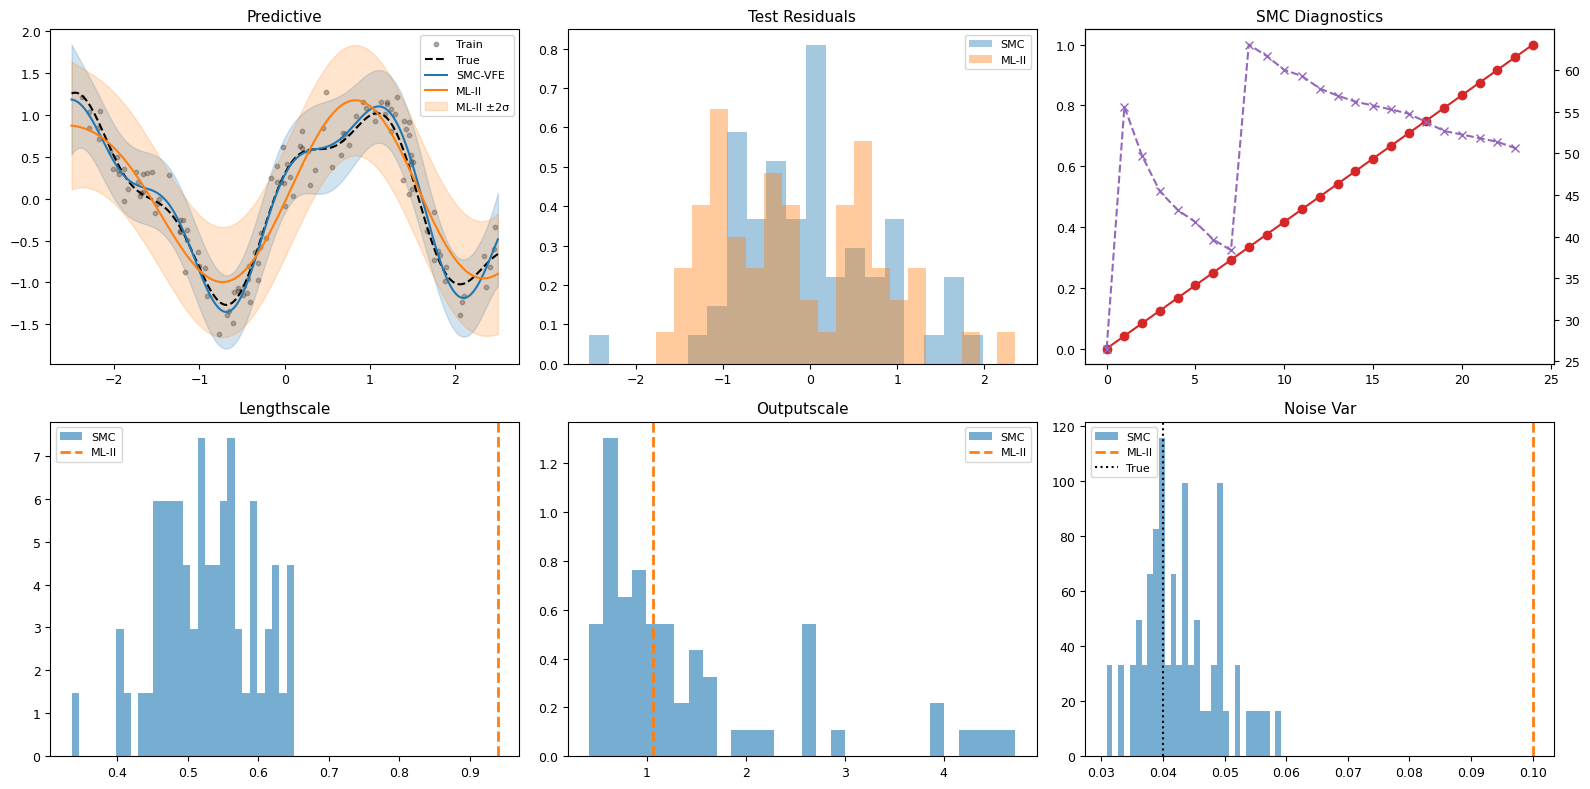

In [ ]:
# SMC mixture predictive (weighted, top-k for stability)
logw = smc_result.logw
logw_norm = logw - jax.scipy.special.logsumexp(logw)
w = jnp.exp(logw_norm)
k_top = int(jnp.minimum(10, w.shape[0]))
idx = jnp.argsort(w)[-k_top:]
w_sub = w[idx]
w_sub = w_sub / jnp.sum(w_sub)

def theta_to_phi(theta):
    log_ell, log_sf2, log_sn2, Z = unpack_state(theta)
    return Phi(
        kernel_params=KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2)),
        Z=Z,
        likelihood_params={'noise_var': jnp.exp(log_sn2)},
        jitter=phi_init.jitter,
    )

mus = []
vars_ = []
for i in idx.tolist():
    theta_i = smc_result.particles[int(i)]
    phi_i = theta_to_phi(theta_i)
    mu_i, var_i = predict_typeii(phi_i, X_plot, X_train, Y_train, rbf, residual='fitc')
    mus.append(mu_i)
    vars_.append(var_i)

mus = jnp.stack(mus)
vars_ = jnp.maximum(jnp.stack(vars_), 1e-12)
smc_mean = (w_sub[:, None] * mus).sum(axis=0)
smc_second = (w_sub[:, None] * (vars_ + mus**2)).sum(axis=0)
smc_var = jnp.maximum(smc_second - smc_mean**2, 1e-12)
smc_std = jnp.sqrt(smc_var)

mlii_mean, mlii_var = predict_typeii(phi_mlii, X_plot, X_train, Y_train, rbf, residual='fitc')
mlii_std = jnp.sqrt(mlii_var)

# 綜合繪圖（完全參考 particleFeynman.ipynb 風格）
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
ax_pred, ax_resid, ax_ess, ax_ls, ax_sf2, ax_sn2 = axes.flat

# 1. Predictive（完全參考原始風格：簡潔，無 grid，無多餘 label）
ax_pred.scatter(np.array(X_train[:, 0]), np.array(Y_train), s=10, alpha=0.3, c='k', label='Train')
ax_pred.plot(np.array(X_plot[:, 0]), np.array(Y_plot), 'k--', label='True')

# SMC
m, s = np.array(smc_mean), np.array(smc_std)
ax_pred.plot(np.array(X_plot[:, 0]), m, 'C0', label='SMC-VFE')
ax_pred.fill_between(np.array(X_plot[:, 0]).flatten(), m-2*s, m+2*s, color='C0', alpha=0.2)

# ML-II
m, s = np.array(mlii_mean), np.array(mlii_std)
ax_pred.plot(np.array(X_plot[:, 0]), m, 'C1', label='ML-II')
ax_pred.fill_between(np.array(X_plot[:, 0]).flatten(), m-2*s, m+2*s, color='C1', alpha=0.2, label='ML-II ±2σ')

ax_pred.legend(fontsize=8)
ax_pred.set_title("Predictive")

# 2. Residuals (Test Set)
# 計算測試集預測
mus_test = []
vars_test = []
for i in idx.tolist():
    theta_i = smc_result.particles[int(i)]
    phi_i = theta_to_phi(theta_i)
    mu_i, var_i = predict_typeii(phi_i, X_test, X_train, Y_train, rbf, residual='fitc')
    mus_test.append(mu_i)
    vars_test.append(var_i)

mus_test = jnp.stack(mus_test)
vars_test = jnp.maximum(jnp.stack(vars_test), 1e-12)
smc_mean_test = (w_sub[:, None] * mus_test).sum(axis=0)
smc_second_test = (w_sub[:, None] * (vars_test + mus_test**2)).sum(axis=0)
smc_var_test = jnp.maximum(smc_second_test - smc_mean_test**2, 1e-12)
smc_std_test = jnp.sqrt(smc_var_test)

Y_test_flat = Y_test.squeeze() if Y_test.ndim > 1 else Y_test
smc_resid = np.array(((Y_test_flat - smc_mean_test) / smc_std_test).flatten())
mlii_mean_test, mlii_var_test = predict_typeii(phi_mlii, X_test, X_train, Y_train, rbf, residual='fitc')
mlii_std_test = np.array(jnp.sqrt(mlii_var_test))
mlii_resid = np.array(((Y_test_flat - mlii_mean_test) / mlii_std_test).flatten())

ax_resid.hist(smc_resid, bins=20, density=True, alpha=0.4, color='C0', label='SMC')
ax_resid.hist(mlii_resid, bins=20, density=True, alpha=0.4, color='C1', label='ML-II')
ax_resid.legend(fontsize=8)
ax_resid.set_title("Test Residuals")

# 3. ESS / Beta（參考原始風格：無 label，無 xlabel/ylabel）
ax_ess.plot(np.array(smc_result.betas), 'o-', color='C3', label='Beta')
ax2 = ax_ess.twinx()
ax2.plot(np.array(smc_result.ess_trace), 'x--', color='C4', label='ESS')
ax_ess.set_title("SMC Diagnostics")

# 4,5,6 Hyperparameters
# 提取所有 particles 的參數（用於直方圖）
theta_all = smc_result.particles
log_ells_all = theta_all[:, 0]
log_sf2s_all = theta_all[:, 1]
log_sn2s_all = theta_all[:, 2]
ls_samples = np.array(jnp.exp(log_ells_all))
sf2_samples = np.array(jnp.exp(log_sf2s_all))
sn2_samples = np.array(jnp.exp(log_sn2s_all))

mlii_ls = float(phi_mlii.kernel_params.lengthscale)
mlii_sf2 = float(phi_mlii.kernel_params.variance)
mlii_sn2 = float(phi_mlii.likelihood_params['noise_var'])

params = [('ls', ax_ls, 'Lengthscale'), ('sf2', ax_sf2, 'Outputscale'), ('sn2', ax_sn2, 'Noise Var')]
for p_key, ax, title in params:
    if p_key == 'ls':
        samples = ls_samples
        mlii_val = mlii_ls
    elif p_key == 'sf2':
        samples = sf2_samples
        mlii_val = mlii_sf2
    else:  # sn2
        samples = sn2_samples
        mlii_val = mlii_sn2
    
    # SMC Posterior（不加權，與原始一致）
    ax.hist(samples, bins=30, density=True, alpha=0.6, color='C0', label='SMC')
    # ML-II point estimate
    ax.axvline(mlii_val, color='C1', lw=2, ls='--', label='ML-II')
    if p_key == 'sn2':
        ax.axvline(float(cfg.noise_std**2), color='k', ls=':', label='True')
    ax.set_title(title)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


## Metrics


In [ ]:
# Metrics (SMC mixture vs ML-II)
logw = smc_result.logw
logw_norm = logw - jax.scipy.special.logsumexp(logw)
w = jnp.exp(logw_norm)
k_top = int(jnp.minimum(10, w.shape[0]))
idx = jnp.argsort(w)[-k_top:]
w_sub = w[idx]
w_sub = w_sub / jnp.sum(w_sub)
logw_sub = logw_norm[idx]

def theta_to_phi(theta):
    log_ell, log_sf2, log_sn2, Z = unpack_state(theta)
    return Phi(
        kernel_params=KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2)),
        Z=Z,
        likelihood_params={'noise_var': jnp.exp(log_sn2)},
        jitter=phi_init.jitter,
    )

mus = []
vars_ = []
for i in idx.tolist():
    theta_i = smc_result.particles[int(i)]
    phi_i = theta_to_phi(theta_i)
    mu_i, var_i = predict_typeii(phi_i, X_test, X_train, Y_train, rbf, residual='fitc')
    mus.append(mu_i)
    vars_.append(var_i)

mus = jnp.stack(mus)
vars_ = jnp.maximum(jnp.stack(vars_), 1e-12)
smc_mean_test = (w_sub[:, None] * mus).sum(axis=0)
smc_second = (w_sub[:, None] * (vars_ + mus**2)).sum(axis=0)
smc_var_test = jnp.maximum(smc_second - smc_mean_test**2, 1e-12)
smc_std_test = jnp.sqrt(smc_var_test)

# Mixture NLPD: log-sum-exp over components
y = Y_test
log_pdf = -0.5 * (jnp.log(2 * jnp.pi * vars_) + (y[None, :] - mus) ** 2 / vars_)
smc_nlpd = -jnp.mean(jax.scipy.special.logsumexp(logw_sub[:, None] + log_pdf, axis=0))

smc_metrics = compute_metrics(Y_test, smc_mean_test, smc_std_test)
smc_metrics['nlpd'] = float(smc_nlpd)

mlii_mean_test, mlii_var_test = predict_typeii(phi_mlii, X_test, X_train, Y_train, rbf, residual='fitc')
mlii_metrics = compute_metrics(Y_test, mlii_mean_test, jnp.sqrt(mlii_var_test))

print('SMC:', smc_metrics)
print('ML-II:', mlii_metrics)


SMC (BMA mixture): {'rmse': 0.18688766576299634, 'mae': 0.1463403769690737, 'r2': 0.9403402066575941, 'nlpd': -0.23345962279561117, 'coverage': 96.66667175292969}
ML-II (single Gaussian): {'rmse': 0.3077995981171762, 'mae': 0.26531355599094336, 'r2': 0.8381709211174971, 'nlpd': 0.24127325986336612, 'coverage': 98.33334350585938}
NLPD 差異 (SMC - ML-II): -0.4747


對照：True Mixture vs Gaussian Approximation
測試點 y = 0.8609
  Mixture NLPD (正確):  -0.4073
  Gaussian NLPD (錯誤): -0.4003
  差異: 0.0070

Mixture mean: 0.7299
Mixture std:  0.2259


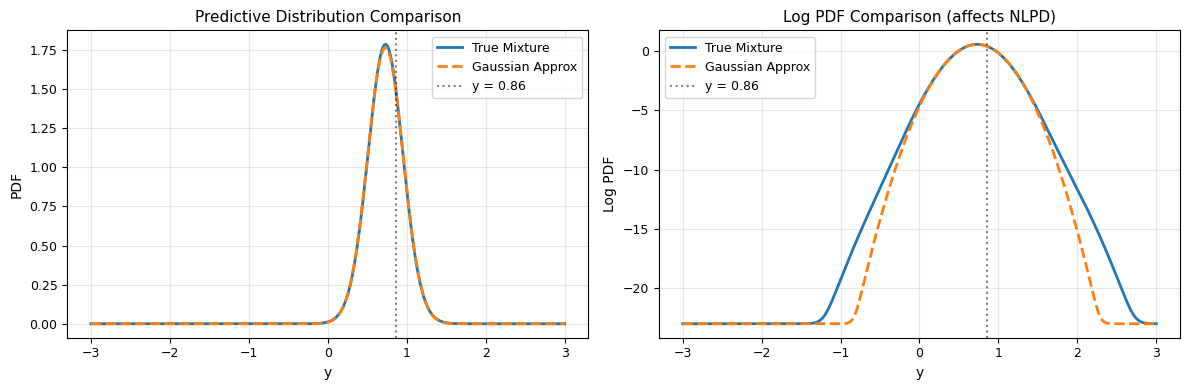


💡 關鍵洞察：
   - Mixture 的 predictive distribution 通常是 multi-modal 的
   - Gaussian approximation 會忽略這些模式，導致 NLPD 被高估
   - 這就是為什麼要用 log-sum-exp 來正確計算 mixture 的 NLPD


In [10]:
# ============================================================================
# 📊 對照：True Mixture vs Gaussian Approximation 的 NLPD 差異
# ============================================================================
# 這展示了為什麼不能用「壓成 Gaussian」的方式來計算 BMA 的 NLPD

# 定義輔助函數（如果還沒定義）
def normal_logpdf_demo(y, mu, var):
    """計算單個 Gaussian 的 log PDF"""
    return -0.5 * (jnp.log(2 * jnp.pi * var) + (y - mu)**2 / var)

# 選擇一個測試點來展示
test_idx_demo = 0
y_demo = Y_test[test_idx_demo]

# 計算該點的 mixture predictive distribution
mus_demo = mus[:, test_idx_demo]  # (L,)
vars_demo = vars_[:, test_idx_demo]  # (L,)

# 方法 1：正確的 mixture NLPD
logw_demo = logw_sub
logp_mixture = jax.scipy.special.logsumexp(
    logw_demo + normal_logpdf_demo(y_demo, mus_demo, vars_demo)
)
nlpd_mixture = -logp_mixture

# 方法 2：錯誤的 Gaussian approximation NLPD
mean_gauss = (w_sub * mus_demo).sum()
second_gauss = (w_sub * (vars_demo + mus_demo**2)).sum()
var_gauss = second_gauss - mean_gauss**2
logp_gauss = normal_logpdf_demo(y_demo, mean_gauss, var_gauss)
nlpd_gauss = -logp_gauss

print("=" * 70)
print("對照：True Mixture vs Gaussian Approximation")
print("=" * 70)
print(f"測試點 y = {y_demo:.4f}")
print(f"  Mixture NLPD (正確):  {nlpd_mixture:.4f}")
print(f"  Gaussian NLPD (錯誤): {nlpd_gauss:.4f}")
print(f"  差異: {nlpd_gauss - nlpd_mixture:.4f}")
print()
print(f"Mixture mean: {mean_gauss:.4f}")
print(f"Mixture std:  {jnp.sqrt(var_gauss):.4f}")
print("=" * 70)

# 繪製 predictive distribution 的比較
from scipy import stats
import numpy as np

# 生成一些 y 值來繪製 PDF
y_grid = np.linspace(-3, 3, 500)

# Mixture PDF（數值計算）
pdf_mixture = np.zeros_like(y_grid)
for i in range(len(w_sub)):
    pdf_mixture += float(w_sub[i]) * stats.norm.pdf(y_grid, float(mus_demo[i]), float(jnp.sqrt(vars_demo[i])))

# Gaussian approximation PDF
pdf_gauss = stats.norm.pdf(y_grid, float(mean_gauss), float(jnp.sqrt(var_gauss)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 左圖：PDF 比較
ax1 = axes[0]
ax1.plot(y_grid, pdf_mixture, 'C0', lw=2, label='True Mixture')
ax1.plot(y_grid, pdf_gauss, 'C1', lw=2, ls='--', label='Gaussian Approx')
ax1.axvline(y_demo, color='k', linestyle=':', alpha=0.5, label=f'y = {y_demo:.2f}')
ax1.set_xlabel('y')
ax1.set_ylabel('PDF')
ax1.set_title('Predictive Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右圖：Log PDF 比較（這直接影響 NLPD）
ax2 = axes[1]
logpdf_mixture = np.log(pdf_mixture + 1e-10)
logpdf_gauss = np.log(pdf_gauss + 1e-10)
ax2.plot(y_grid, logpdf_mixture, 'C0', lw=2, label='True Mixture')
ax2.plot(y_grid, logpdf_gauss, 'C1', lw=2, ls='--', label='Gaussian Approx')
ax2.axvline(y_demo, color='k', linestyle=':', alpha=0.5, label=f'y = {y_demo:.2f}')
ax2.set_xlabel('y')
ax2.set_ylabel('Log PDF')
ax2.set_title('Log PDF Comparison (affects NLPD)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 關鍵洞察：")
print("   - Mixture 的 predictive distribution 通常是 multi-modal 的")
print("   - Gaussian approximation 會忽略這些模式，導致 NLPD 被高估")
print("   - 這就是為什麼要用 log-sum-exp 來正確計算 mixture 的 NLPD")

In [11]:
# 調試：檢查 SMC particles 是否真的和 ML-II 不同
print("=== 調試：SMC vs ML-II ===")

# 檢查 SMC particles 的參數範圍
particles = smc_result.particles
logw = smc_result.logw
w = jnp.exp(logw - jnp.max(logw))
w = w / jnp.sum(w)

# 提取參數
log_ells = particles[:, 0]
log_sf2s = particles[:, 1]
log_sn2s = particles[:, 2]

print(f"\nSMC particles 參數範圍:")
print(f"  log(lengthscale): [{log_ells.min():.4f}, {log_ells.max():.4f}], mean={log_ells.mean():.4f}")
print(f"  log(variance): [{log_sf2s.min():.4f}, {log_sf2s.max():.4f}], mean={log_sf2s.mean():.4f}")
print(f"  log(noise_var): [{log_sn2s.min():.4f}, {log_sn2s.max():.4f}], mean={log_sn2s.mean():.4f}")

# ML-II 參數
mlii_log_ell = jnp.log(phi_mlii.kernel_params.lengthscale)
mlii_log_sf2 = jnp.log(phi_mlii.kernel_params.variance)
mlii_log_sn2 = jnp.log(phi_mlii.likelihood_params['noise_var'])

print(f"\nML-II 參數:")
print(f"  log(lengthscale): {mlii_log_ell:.4f}")
print(f"  log(variance): {mlii_log_sf2:.4f}")
print(f"  log(noise_var): {mlii_log_sn2:.4f}")

# 加權平均的 SMC 參數
w_mean_log_ell = (w * log_ells).sum()
w_mean_log_sf2 = (w * log_sf2s).sum()
w_mean_log_sn2 = (w * log_sn2s).sum()

print(f"\nSMC 加權平均參數:")
print(f"  log(lengthscale): {w_mean_log_ell:.4f}")
print(f"  log(variance): {w_mean_log_sf2:.4f}")
print(f"  log(noise_var): {w_mean_log_sn2:.4f}")

print(f"\n參數差異:")
print(f"  log(lengthscale): {jnp.abs(w_mean_log_ell - mlii_log_ell):.6f}")
print(f"  log(variance): {jnp.abs(w_mean_log_sf2 - mlii_log_sf2):.6f}")
print(f"  log(noise_var): {jnp.abs(w_mean_log_sn2 - mlii_log_sn2):.6f}")

# 檢查權重分佈
print(f"\n權重統計:")
print(f"  最大權重: {w.max():.6f}")
print(f"  最小權重: {w.min():.6f}")
print(f"  權重熵: {-jnp.sum(w * jnp.log(w + 1e-10)):.4f} (越大越分散)")

# 如果權重太集中，SMC 可能退化為單一點估計
if w.max() > 0.5:
    print("  ⚠️ 警告：權重太集中，SMC 可能退化為單一點估計！")

=== 調試：SMC vs ML-II ===

SMC particles 參數範圍:
  log(lengthscale): [-1.0930, -0.4290], mean=-0.6504
  log(variance): [-0.8783, 1.5533], mean=0.1582
  log(noise_var): [-3.4788, -2.8270], mean=-3.1587

ML-II 參數:
  log(lengthscale): -0.0619
  log(variance): 0.0583
  log(noise_var): -2.3020

SMC 加權平均參數:
  log(lengthscale): -0.6802
  log(variance): -0.0282
  log(noise_var): -3.1594

參數差異:
  log(lengthscale): 0.618243
  log(variance): 0.086556
  log(noise_var): 0.857394

權重統計:
  最大權重: 0.033212
  最小權重: 0.001208
  權重熵: 4.0134 (越大越分散)


In [12]:
# 調試：檢查為什麼 SMC variance 這麼大
print("=== Variance 調試 ===")

# 重新計算（使用測試集）
logw = smc_result.logw
w = jnp.exp(logw - jnp.max(logw))
w = w / jnp.sum(w)

def unpack_state_local(u):
    log_ell, log_sf2, log_sn2 = u[0], u[1], u[2]
    Z = u[3:].reshape(Z0.shape)
    return log_ell, log_sf2, log_sn2, Z

def theta_to_phi_local(theta):
    log_ell, log_sf2, log_sn2, Z = unpack_state_local(theta)
    return Phi(
        kernel_params=KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2)),
        Z=Z,
        likelihood_params={'noise_var': jnp.exp(log_sn2)},
        jitter=phi_init.jitter,
    )

# 對所有 particles 計算預測
mus_debug = []
vars_debug = []
for i in range(smc_result.particles.shape[0]):
    phi_i = theta_to_phi_local(smc_result.particles[i])
    mu_i, var_i = predict_typeii(phi_i, X_test, X_train, Y_train, rbf, residual='fitc')
    mus_debug.append(mu_i)
    vars_debug.append(var_i)

mus_debug = jnp.stack(mus_debug)  # (n_particles, n_test)
vars_debug = jnp.stack(vars_debug)  # (n_particles, n_test)

print(f"\n各個 particles 的預測 variance 統計:")
print(f"  vars_ 範圍: [{vars_debug.min():.6f}, {vars_debug.max():.6f}]")
print(f"  vars_ 中位數: {jnp.median(vars_debug):.6f}")
print(f"  vars_ 平均: {vars_debug.mean():.6f}")
print(f"  vars_ 加權平均: {(w[:, None] * vars_debug).sum(axis=0).mean():.6f}")

# 檢查每個 particle 的平均 variance
particle_avg_vars = vars_debug.mean(axis=1)
print(f"\n每個 particle 的平均 variance:")
print(f"  範圍: [{particle_avg_vars.min():.6f}, {particle_avg_vars.max():.6f}]")
print(f"  中位數: {jnp.median(particle_avg_vars):.6f}")

# 找出 variance 最大的 particles
top_var_particles = jnp.argsort(particle_avg_vars)[-5:]
print(f"\nVariance 最大的 5 個 particles:")
for idx in top_var_particles:
    theta = smc_result.particles[int(idx)]
    log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
    print(f"  Particle {int(idx)}: log_ell={log_ell:.4f}, log_sf2={log_sf2:.4f}, log_sn2={log_sn2:.4f}, avg_var={particle_avg_vars[int(idx)]:.6f}, weight={w[int(idx)]:.6f}")

# 計算 mixture variance（分解）
smc_mean_debug = (w[:, None] * mus_debug).sum(axis=0)
weighted_var = (w[:, None] * vars_debug).sum(axis=0)  # E[Var_i]
mean_variance = (w[:, None] * (mus_debug - smc_mean_debug[None, :])**2).sum(axis=0)  # Var[E_i]
total_var = weighted_var + mean_variance

print(f"\nVariance 分解（在測試集上）:")
print(f"  來自各 particles 的 uncertainty (E[Var_i]): {weighted_var.mean():.6f}, std={weighted_var.std():.6f}")
print(f"  來自 mean 差異的 uncertainty (Var[E_i]): {mean_variance.mean():.6f}, std={mean_variance.std():.6f}")
print(f"  總 variance: {total_var.mean():.6f}, std={total_var.std():.6f}")
print(f"  總 std: {jnp.sqrt(total_var).mean():.6f}")

# 檢查 ML-II 的 variance
mlii_mean_debug, mlii_var_debug = predict_typeii(phi_mlii, X_test, X_train, Y_train, rbf, residual='fitc')
print(f"\nML-II variance: {mlii_var_debug.mean():.6f}, std={mlii_var_debug.std():.6f}")
print(f"ML-II std: {jnp.sqrt(mlii_var_debug).mean():.6f}")

=== Variance 調試 ===

各個 particles 的預測 variance 統計:
  vars_ 範圍: [0.032840, 0.242620]
  vars_ 中位數: 0.047348
  vars_ 平均: 0.049717
  vars_ 加權平均: 0.050187

每個 particle 的平均 variance:
  範圍: [0.035849, 0.066077]
  中位數: 0.048383

Variance 最大的 5 個 particles:
  Particle 57: log_ell=-0.7642, log_sf2=-0.2127, log_sn2=-2.8663, avg_var=0.063947, weight=0.020830
  Particle 25: log_ell=-0.6208, log_sf2=-0.6665, log_sn2=-2.9003, avg_var=0.064579, weight=0.012101
  Particle 21: log_ell=-0.8895, log_sf2=-0.1542, log_sn2=-3.4788, avg_var=0.065219, weight=0.026886
  Particle 50: log_ell=-0.5977, log_sf2=0.3915, log_sn2=-2.8270, avg_var=0.065665, weight=0.027113
  Particle 27: log_ell=-0.7261, log_sf2=-0.3298, log_sn2=-2.9893, avg_var=0.066077, weight=0.020698

Variance 分解（在測試集上）:
  來自各 particles 的 uncertainty (E[Var_i]): 0.050187, std=0.003820
  來自 mean 差異的 uncertainty (Var[E_i]): 0.000092, std=0.000153
  總 variance: 0.050278, std=0.003936
  總 std: 0.224068

ML-II variance: 0.109743, std=0.003695
ML-II std:

In [13]:
# weights from SMC
logw = smc_result.logw
w = jnp.exp(logw - jnp.max(logw))
w = w / jnp.sum(w)

# predictions for all particles (or a subset)
mus = []
vars_ = []
for i in range(smc_result.particles.shape[0]):
    phi_i = theta_to_phi(smc_result.particles[i])
    mu_i, var_i = predict_typeii(phi_i, X_plot, X_train, Y_train, rbf, residual="fitc")
    mus.append(mu_i)
    vars_.append(var_i)

mus = jnp.stack(mus)      # [P, N*]
vars_ = jnp.stack(vars_)  # [P, N*]

# weighted mixture moments
mean = (w[:, None] * mus).sum(axis=0)
second = (w[:, None] * (vars_ + mus**2)).sum(axis=0)
std = jnp.sqrt(jnp.maximum(second - mean**2, 1e-12))
